In [31]:
# FFNN for Toy data
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

## Generating Data

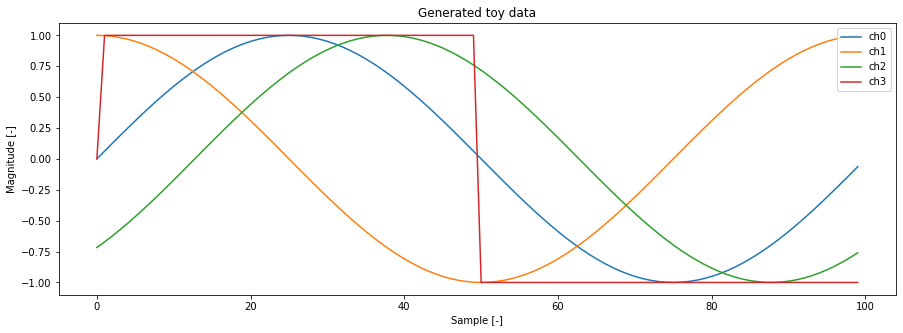

In [29]:
N_samples = 1000
N_turns = 10
x0 = np.sin(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x1 = np.cos(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x2 = np.sin(np.arange(-0.8, N_turns*2*np.pi-0.8, N_turns*2*np.pi/N_samples))
x3 = x0.copy()
x3[x3 > 0] = 1
x3[x3 < 0] = -1
data = np.array([x0, x1, x2, x3]).transpose()
plt.figure(figsize=(15,5))
plt.title('Generated toy data')
plt.plot(data[:100,:])
plt.xlabel('Sample [-]'), plt.ylabel('Magnitude [-]')
plt.legend(['ch0', 'ch1', 'ch2', 'ch3'])
plt.savefig('fig_0422_toy_data.png')

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * N_samples), :]
test_set = data[int(train_portion * N_samples):, :]

## FFNN

In [7]:
class FFNN(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        # Parameters
        self.in_size = in_size
        self.out_size = out_size
        self.channel_size = self.in_size + self.out_size
        # Create FC Layer
        fc_in = self.in_size + self.out_size
        fc_out = self.out_size
        self.fc = nn.Linear(fc_in, fc_out)
        # Initialize Weights
        k = np.sqrt(1 / fc_in)
        self.weights = torch.FloatTensor(self.channel_size, self.channel_size).uniform_(-k, k)
        #self.weights = torch.zeros(self.channel_size, self.channel_size)
        self.bias = torch.zeros(self.channel_size)

    def save_weights(self, in_pos: list, out_pos: int):
        with torch.no_grad():
            for idx, pos in enumerate(in_pos):
                self.weights[pos, out_pos] = self.fc.weight[0][idx]
            self.weights[out_pos, out_pos] = self.fc.weight[0][-1]
            self.bias[out_pos] = self.fc.bias[0]

    def get_weights(self, in_pos: list, out_pos: int):
        with torch.no_grad():
            for idx, pos in enumerate(in_pos):
                self.fc.weight[0][idx] = self.weights[pos, out_pos]
            self.fc.weight[0][-1] = self.weights[out_pos, out_pos]
            self.fc.bias[0] = self.bias[out_pos]

    def forward(self, X):
        # Initialize hidden node
        h = torch.zeros(self.out_size, dtype=torch.float32)
        # Forward path
        for i in range(X.shape[0]):
            fc_in = torch.cat((X[i, :], h), 0)
            h = torch.tanh(self.fc(fc_in))
        return h

# First Rotation

In [8]:
# prepare data for learning
window_size = 50
ch_in = [0, 1, 2]
ch_out = [3]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

Data is prepared for first rotation. After Training, the learned weights are saved in the model.

In [9]:
model = FFNN(len(ch_in), len(ch_out))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')
    
model.save_weights(ch_in, ch_out[0])
    
total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

Epoch: 0 Loss: 0.5769370252514879
Epoch: 1 Loss: 0.37884490262313436
Epoch: 2 Loss: 0.2873688861326211
Epoch: 3 Loss: 0.23559339732211082
Epoch: 4 Loss: 0.20226015586343904
Epoch: 5 Loss: 0.17889551543556284
Epoch: 6 Loss: 0.16153331596678167
Epoch: 7 Loss: 0.14807582026346305
Epoch: 8 Loss: 0.13730770427425806
Epoch: 9 Loss: 0.12847468114448324
Time used [s]: 36.26792931556702


Weights: tensor([[ 1.6212,  0.2847, -0.1492,  1.1508]])
Bias: tensor([-0.0159])
WMat: tensor([[-0.2816,  0.4367, -0.4689,  1.6212],
        [-0.3534, -0.1030,  0.2952,  0.2847],
        [ 0.4669, -0.4074,  0.0956, -0.1492],
        [-0.3688,  0.0076,  0.2264,  1.1508]])
VBias: tensor([ 0.0000,  0.0000,  0.0000, -0.0159])


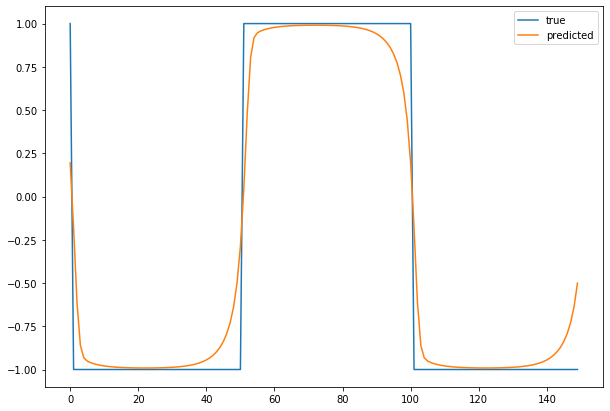

In [10]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()
fig.savefig('fig_0422_result_1-rotation.png')

print('Weights: ' + str(model.fc.weight.data))
print('Bias: ' + str(model.fc.bias.data))
print('WMat: ' + str(model.weights))
print('VBias: ' + str(model.bias))

# Second Rotation

In [11]:
# prepare data for learning
ch_in = [1, 2, 3]
ch_out = [0]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

To not train on the previous weights, new initial weights are loaded with model.get_weights(). Not sure if that is necessary.

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

model.get_weights(ch_in, ch_out[0])

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')
    
model.save_weights(ch_in, ch_out[0])
    
total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

Epoch: 0 Loss: 0.42516869602208546
Epoch: 1 Loss: 0.2678619362101229
Epoch: 2 Loss: 0.1950121484481673
Epoch: 3 Loss: 0.15653968991125214
Epoch: 4 Loss: 0.1321583033315315
Epoch: 5 Loss: 0.11475961017499685
Epoch: 6 Loss: 0.10136360514874596
Epoch: 7 Loss: 0.09056391516037657
Epoch: 8 Loss: 0.08168334484987155
Epoch: 9 Loss: 0.0743732662604513
Time used [s]: 43.081682443618774


Weights: tensor([[ 0.9089,  1.2056, -0.0768,  0.5613]])
Bias: tensor([0.0016])
WMat: tensor([[ 0.5613,  0.4367, -0.4689,  1.6212],
        [ 0.9089, -0.1030,  0.2952,  0.2847],
        [ 1.2056, -0.4074,  0.0956, -0.1492],
        [-0.0768,  0.0076,  0.2264,  1.1508]])
VBias: tensor([ 0.0016,  0.0000,  0.0000, -0.0159])


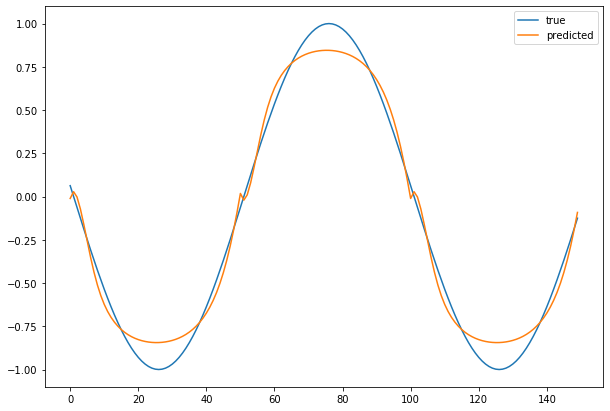

In [13]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

print('Weights: ' + str(model.fc.weight.data))
print('Bias: ' + str(model.fc.bias.data))
print('WMat: ' + str(model.weights))
print('VBias: ' + str(model.bias))

# Third Rotation

In [14]:
# prepare data for learning
ch_in = [2, 3, 0]
ch_out = [1]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

model.get_weights(ch_in, ch_out[0])

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')
    
model.save_weights(ch_in, ch_out[0])
    
total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

Epoch: 0 Loss: 0.12881016862006534
Epoch: 1 Loss: 0.07225776466313097
Epoch: 2 Loss: 0.05268495690747634
Epoch: 3 Loss: 0.04285401384861367
Epoch: 4 Loss: 0.03690078881934614
Epoch: 5 Loss: 0.03287969942186189
Epoch: 6 Loss: 0.02996097932641066
Epoch: 7 Loss: 0.027731564031037693
Epoch: 8 Loss: 0.025962703357444678
Epoch: 9 Loss: 0.02451740444600605
Time used [s]: 44.3604416847229


Weights: tensor([[-1.0738,  0.0448,  0.6733,  0.4895]])
Bias: tensor([-0.0033])
WMat: tensor([[ 0.5613,  0.6733, -0.4689,  1.6212],
        [ 0.9089,  0.4895,  0.2952,  0.2847],
        [ 1.2056, -1.0738,  0.0956, -0.1492],
        [-0.0768,  0.0448,  0.2264,  1.1508]])
VBias: tensor([ 0.0016, -0.0033,  0.0000, -0.0159])


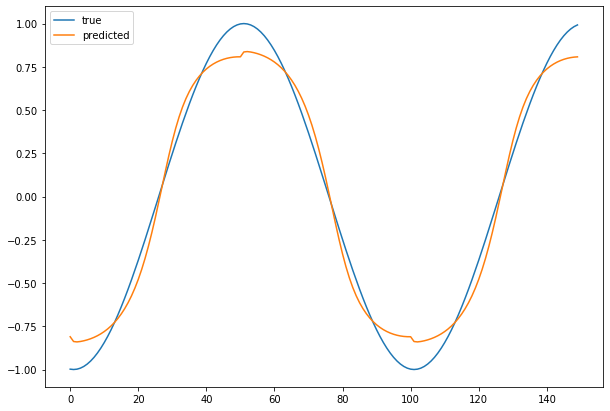

In [16]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

print('Weights: ' + str(model.fc.weight.data))
print('Bias: ' + str(model.fc.bias.data))
print('WMat: ' + str(model.weights))
print('VBias: ' + str(model.bias))

# Fourth Rotation

In [17]:
# prepare data for learning
ch_in = [3, 0, 1]
ch_out = [2]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

model.get_weights(ch_in, ch_out[0])

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')
    
model.save_weights(ch_in, ch_out[0])
    
total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

Epoch: 0 Loss: 0.48948545625366147
Epoch: 1 Loss: 0.3067512642139552
Epoch: 2 Loss: 0.20962542466626075
Epoch: 3 Loss: 0.1585176809207894
Epoch: 4 Loss: 0.12783727687388324
Epoch: 5 Loss: 0.10738661165764668
Epoch: 6 Loss: 0.09277830067956214
Epoch: 7 Loss: 0.08181768361974565
Epoch: 8 Loss: 0.07328577746464912
Epoch: 9 Loss: 0.06645215895520677
Time used [s]: 42.11169171333313


Weights: tensor([[ 0.4005,  0.1560, -0.7160,  0.5166]])
Bias: tensor([-0.0002])
WMat: tensor([[ 0.5613,  0.6733,  0.1560,  1.6212],
        [ 0.9089,  0.4895, -0.7160,  0.2847],
        [ 1.2056, -1.0738,  0.5166, -0.1492],
        [-0.0768,  0.0448,  0.4005,  1.1508]])
VBias: tensor([ 0.0016, -0.0033, -0.0002, -0.0159])


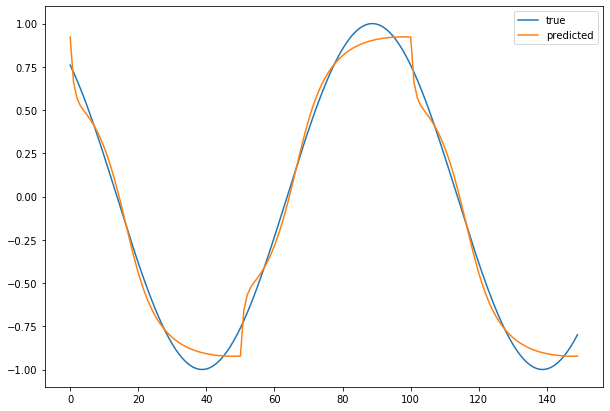

In [19]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

print('Weights: ' + str(model.fc.weight.data))
print('Bias: ' + str(model.fc.bias.data))
print('WMat: ' + str(model.weights))
print('VBias: ' + str(model.bias))

## Test Rotations
To test the stored weights, an evaluation is performed with the previous learned weights and the channel setup from the first rotation. After that, the weights from the first rotation are loaded and the evaluation is performed again.

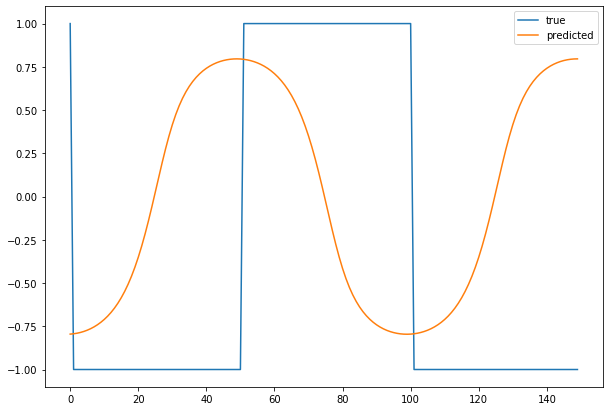

In [20]:
# prepare data for learning
ch_in = [0, 1, 2]
ch_out = [3]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])
    
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

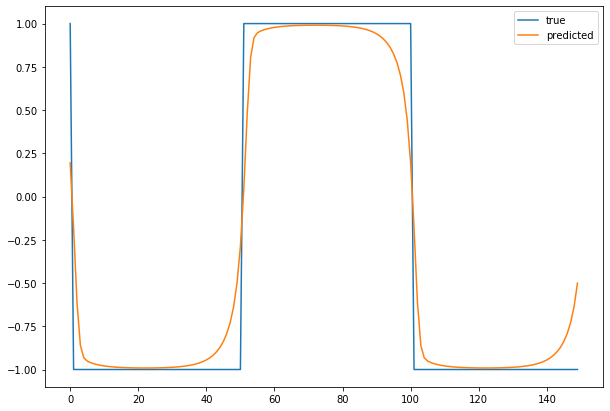

In [21]:
model.get_weights(ch_in, ch_out[0])

model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

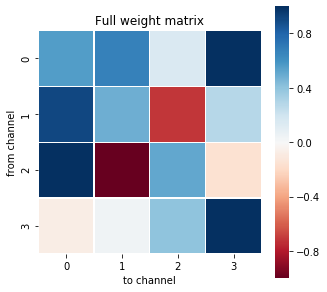

In [28]:
fig, ax= plt.subplots(figsize = (5, 5))
ax.set_title('Full weight matrix')
sns.heatmap(model.weights,cmap='RdBu', vmin=-1, vmax=1, linewidths=0.01, square=True)
ax.set_ylabel('from channel'), ax.set_xlabel('to channel')
fig.savefig('fig_0422_weights_rotation.png')

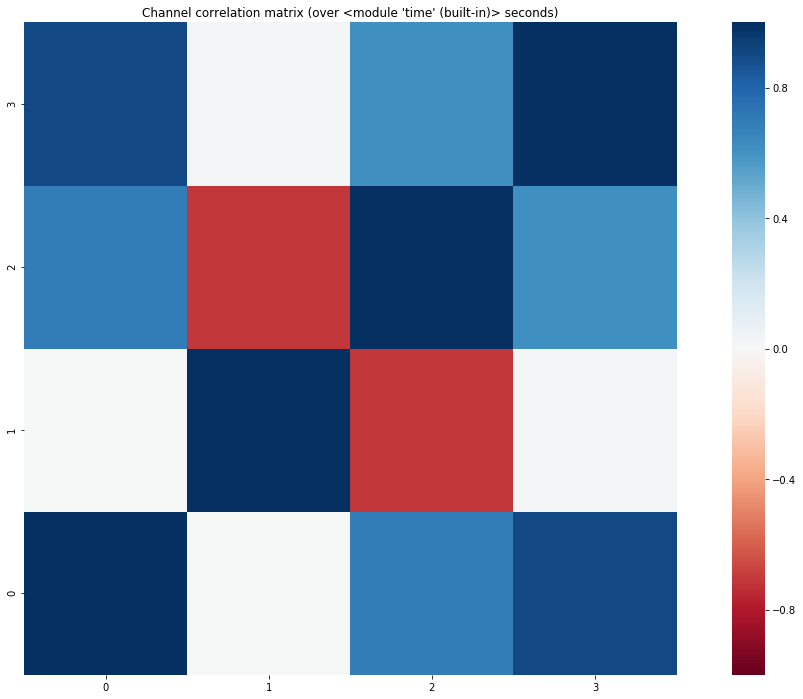

In [33]:
data.shape

torch.Size([1000, 4])